In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

from plotting import plot_utils, summary_plots, load_fits, plot_prf_params, pycortex_plot_utils
plot_utils.set_all_font_sizes(12)
from utils import roi_utils, default_paths, stats_utils, nsd_utils

In [3]:
# Load results of the fitting procedure
subjects = np.arange(1,9)
n_subjects = len(subjects)

feature_type_list_long = ['gabor_solo_ridge_12ori_8sf','gabor_solo_ridge_12ori_8sf_from_residuals', \
                          'all_coco', \
                          'alexnet_all_conv_pca']
feature_type_list = ['gabor','gabor_cocoresid', 'coco', 'alexnet']

n_models = len(feature_type_list)
out_list = []
for fi, fitting_type in enumerate(feature_type_list_long):

    out = [load_fits.load_fit_results(subject=ss, fitting_type=fitting_type, \
                                      n_from_end=0, verbose=False) \
           for ss in subjects]
    out_list.append(out)
    
out = out_list
    
fig_save_folder=None

In [4]:
out[0][0]['partial_version_names']

['full_model']

In [5]:
for oo in out:
    print([o['average_image_reps'] for o in oo])

[True, True, True, True, True, True, True, True]
[True, True, True, True, True, True, True, True]
[True, True, True, True, True, True, True, True]
[True, True, True, True, True, True, True, True]


In [6]:
for oo in out:
    print([o['shuff_rnd_seed'] for o in oo])

[0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0]
[0, 0, 0, 0, 0, 0, 0, 0]
[171301, 42102, 490304, 521005, 11407, 501610, 552211, 450013]


In [22]:
# for oo in out:
    # print([o['saved_prfs_fn'] for o in oo])

In [7]:
# initialize roi_def objects to get roi indices
roi_def = roi_utils.multi_subject_roi_def(subjects, remove_ret_overlap=True, \
                                          remove_categ_overlap=True)
roi_names =roi_def.roi_names
n_rois = roi_def.n_rois

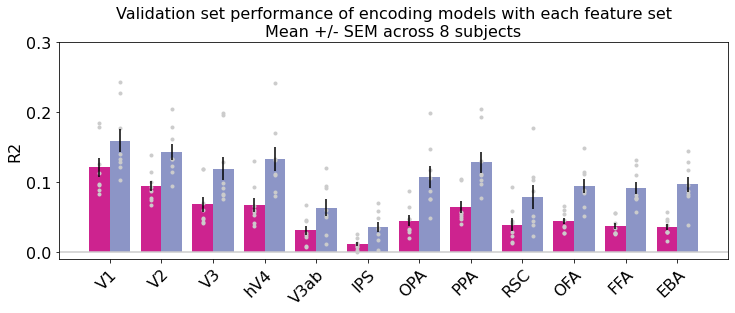

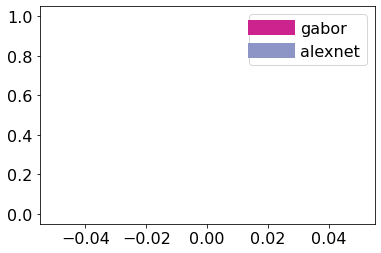

In [16]:
# Plot Gabor and AlexNet

mm2plot = [0,3]

dnn_colors = cm.BuPu(np.linspace(0,1,3))[1:2,:]
gabor_colors = cm.RdPu(np.linspace(0,1,4))[2:3,:]

colors = np.concatenate([gabor_colors, dnn_colors], axis=0)

nc_thresh = 0.01

vals = np.zeros((n_subjects, n_rois, len(mm2plot)))

for fi, mm in enumerate(mm2plot):

    for si, ss in enumerate(subjects):

        val_r2 = out[mm][si]['val_r2'][:,0]    
        
        nc = nsd_utils.ncsnr_to_nc(out[fi][si]['voxel_ncsnr'][out[fi][si]['voxel_mask']])/100
        inds2use = nc>nc_thresh

        for ri in range(n_rois):

            inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & inds2use
        
            vals[si,ri,fi] = np.mean(val_r2[inds_this_roi])

mean_vals = np.mean(vals, axis=0)
sem_vals = np.std(vals, axis=0) / np.sqrt(n_subjects)

legend_separate=True
title='Validation set performance of encoding models with each feature set\nMean +/- SEM across 8 subjects'

plt.rcParams['pdf.fonttype']=42

plot_utils.set_all_font_sizes(fs = 16)
bw = 0.4;
space = (1 - (bw*mean_vals.shape[1]))/2
fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, \
                                point_data=vals,\
                                colors=colors, space=space, \
                xticklabels=roi_names, ylabel='R2', \
                ylim=[-0.01, 0.30], title=title, horizontal_line_pos=0,\
                legend_labels=np.array(feature_type_list)[mm2plot], \
                legend_overlaid=False, legend_separate=True, \
                fig_size=(12,4))


# plt.rcParams.update({'font.size': 10})
# plt.rcParams['ps.fonttype']=42    
fn2save = '/user_data/mmhender/imStat/figures/all_visual_R2.pdf'
plt.savefig(fn2save)

#### Plot Gabor, COCO-all, and Gabor fit to residuals of COCO-all
Use the same set of voxels as in Figure 5 - need to threshold based on R2 of the two gabor fits.

In [22]:
r2_cutoff = 0.01
val_r2_1 = np.concatenate([out[0][si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)
val_r2_2 = np.concatenate([out[1][si]['val_r2'][:,0] for si in range(n_subjects)], axis=0)
abv_thresh = (val_r2_1>r2_cutoff) & (val_r2_2>r2_cutoff)

#### how many voxels were left after thresholding?

In [23]:
n_vox_each_subj = [out[0][si]['best_params'][0].shape[0] for si in range(n_subjects)]
subject_inds = np.concatenate([si*np.ones((n_vox_each_subj[si],),dtype=int) \
                               for si in range(n_subjects)], axis=0)

thresh_sizes = np.zeros((n_subjects, n_rois),dtype=int)
orig_sizes = np.zeros((n_subjects, n_rois),dtype=int)
for ss in range(n_subjects):
    for rr in range(n_rois):
        orig_sizes[ss,rr] = np.sum(roi_def.get_indices(rr) \
                                     & (subject_inds==ss))
        thresh_sizes[ss,rr] = np.sum(roi_def.get_indices(rr) \
                                     & abv_thresh \
                                     & (subject_inds==ss))
        

In [26]:
import pandas as pd
pd.DataFrame(thresh_sizes, index=subjects, columns=roi_names)

,V1,V2,V3,hV4,V3ab,IPS,OPA,PPA,RSC,OFA,FFA,EBA
1,1547,1372,1183,421,204,125,460,222,74,219,263,736
2,1092,878,965,353,200,206,531,408,296,246,386,638
3,1243,986,796,216,176,55,82,151,71,304,156,345
4,797,747,559,157,79,16,198,179,194,176,149,135
5,1078,887,685,288,151,121,430,459,76,366,136,493
6,1123,1025,858,384,78,80,228,179,20,166,79,291
7,1062,838,516,255,37,86,314,129,13,113,98,313
8,767,681,519,227,15,11,78,77,7,95,277,191


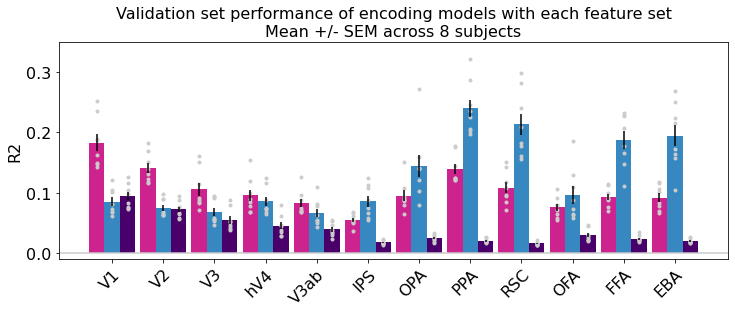

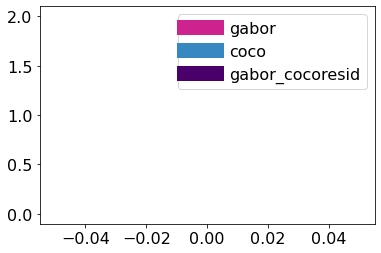

In [32]:
# Plot Gabor, COCO-all, and residuals

mm2plot = [0,2,1]

gabor_color1 = cm.RdPu(np.linspace(0,1,4))[2:3,:]
gabor_color2 = cm.RdPu(np.linspace(0,1,4))[3:4,:]
sem_colors = cm.Blues(np.linspace(0,1,4))[2:3,:]

colors = np.concatenate([gabor_color1, sem_colors, gabor_color2], axis=0)

nc_thresh = 0.01

vals = np.zeros((n_subjects, n_rois, len(mm2plot)))

for fi, mm in enumerate(mm2plot):

    for si, ss in enumerate(subjects):

        val_r2 = out[mm][si]['val_r2'][:,0]    
        
        for ri in range(n_rois):

            inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & abv_thresh[subject_inds==si]
        
            vals[si,ri,fi] = np.mean(val_r2[inds_this_roi])

mean_vals = np.mean(vals, axis=0)
sem_vals = np.std(vals, axis=0) / np.sqrt(n_subjects)

legend_separate=True
title='Validation set performance of encoding models with each feature set\nMean +/- SEM across 8 subjects'

plt.rcParams['pdf.fonttype']=42

plot_utils.set_all_font_sizes(fs = 16)
bw = 0.3;
space = (1 - (bw*mean_vals.shape[1]))/2
fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, \
                                point_data=vals,\
                                colors=colors, space=space, \
                xticklabels=roi_names, ylabel='R2', \
                ylim=[-0.01, 0.35], title=title, horizontal_line_pos=0,\
                legend_labels=np.array(feature_type_list)[mm2plot], \
                legend_overlaid=False, legend_separate=True, \
                fig_size=(12,4))


# plt.rcParams.update({'font.size': 10})
# plt.rcParams['ps.fonttype']=42    
# fn2save = '/user_data/mmhender/imStat/figures/all_visual_R2.pdf'
# plt.savefig(fn2save)

In [31]:
np.max(vals)

0.321712851524353

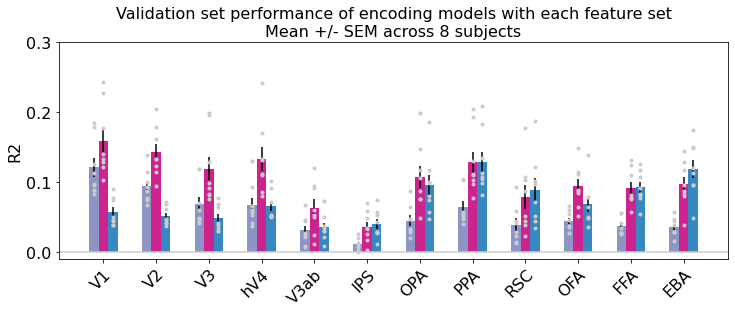

In [11]:
# Plot just the midlevel models

# mm2plot = [0,1,2,3,4]

mm2plot = [0,2,1]

# colors = cm.BuPu(np.linspace(0,1,7))[1:7,:]

colors = cm.BuPu(np.linspace(0,1,3))[1:4,:]
sem_colors = cm.Blues(np.linspace(0,1,4))[2:3,:]
dnn_colors = cm.RdPu(np.linspace(0,1,4))[2:3,:]
# colors = np.concatenate([colors[0:1,:], sem_colors, dnn_colors], axis=0)
colors = np.concatenate([colors[0:1,:], dnn_colors, sem_colors], axis=0)
# colors = cm.Purples(np.linspace(0,1,6))[1:5,:]

nc_thresh = 0.01

vals = np.zeros((n_subjects, n_rois, len(mm2plot)))

for fi, mm in enumerate(mm2plot):

    for si, ss in enumerate(subjects):

        val_r2 = out[mm][si]['val_r2'][:,0]    
        
        nc = nsd_utils.ncsnr_to_nc(out[fi][si]['voxel_ncsnr'][out[fi][si]['voxel_mask']])/100
        inds2use = nc>nc_thresh

        for ri in range(n_rois):

            inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & inds2use
        
            vals[si,ri,fi] = np.mean(val_r2[inds_this_roi])

mean_vals = np.mean(vals, axis=0)
sem_vals = np.std(vals, axis=0) / np.sqrt(n_subjects)

legend_separate=True
title='Validation set performance of encoding models with each feature set\nMean +/- SEM across 8 subjects'

plt.rcParams['pdf.fonttype']=42

plot_utils.set_all_font_sizes(fs = 16)
bw = 0.18;
space = (1 - (bw*mean_vals.shape[1]))/2
fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, \
                                point_data=vals,\
                                colors=colors, space=space, \
                xticklabels=roi_names, ylabel='R2', \
                ylim=[-0.01, 0.30], title=title, horizontal_line_pos=0,\
                legend_labels=np.array(feature_type_list)[mm2plot], \
                legend_overlaid=False, legend_separate=False, \
                fig_size=(12,4))


# plt.rcParams.update({'font.size': 10})
# plt.rcParams['ps.fonttype']=42    
fn2save = '/user_data/mmhender/imStat/figures/all_visual_R2.pdf'
plt.savefig(fn2save)

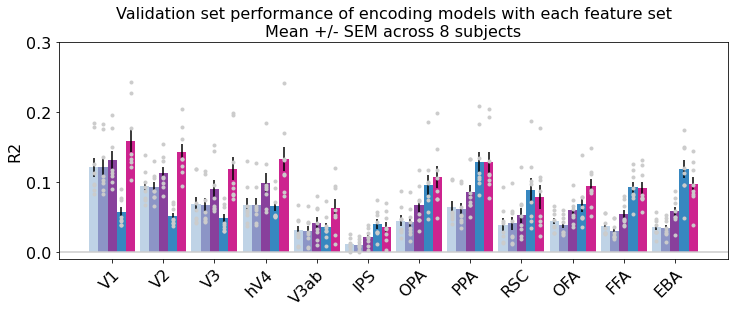

In [20]:
# Plot just the midlevel models

# mm2plot = [0,1,2,3,4]

mm2plot = [0,1,2,3,4]

# colors = cm.BuPu(np.linspace(0,1,7))[1:7,:]

colors = cm.BuPu(np.linspace(0,1,5))[1:4,:]
sem_colors = cm.Blues(np.linspace(0,1,4))[2:3,:]
dnn_colors = cm.RdPu(np.linspace(0,1,4))[2:3,:]
colors = np.concatenate([colors, sem_colors, dnn_colors], axis=0)
# colors = cm.Purples(np.linspace(0,1,6))[1:5,:]

nc_thresh = 0.01

vals = np.zeros((n_subjects, n_rois, len(mm2plot)))

for fi, mm in enumerate(mm2plot):

    for si, ss in enumerate(subjects):

        val_r2 = out[mm][si]['val_r2'][:,0]    
        
        nc = nsd_utils.ncsnr_to_nc(out[fi][si]['voxel_ncsnr'][out[fi][si]['voxel_mask']])/100
        inds2use = nc>nc_thresh

        for ri in range(n_rois):

            inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & inds2use
        
            vals[si,ri,fi] = np.mean(val_r2[inds_this_roi])

mean_vals = np.mean(vals, axis=0)
sem_vals = np.std(vals, axis=0) / np.sqrt(n_subjects)

legend_separate=True
title='Validation set performance of encoding models with each feature set\nMean +/- SEM across 8 subjects'

plt.rcParams['pdf.fonttype']=42

plot_utils.set_all_font_sizes(fs = 16)
bw = 0.18;
space = (1 - (bw*mean_vals.shape[1]))/2
fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, \
                                point_data=vals,\
                                colors=colors, space=space, \
                xticklabels=roi_names, ylabel='R2', \
                ylim=[-0.01, 0.30], title=title, horizontal_line_pos=0,\
                legend_labels=np.array(feature_type_list)[mm2plot], \
                legend_overlaid=False, legend_separate=False, \
                fig_size=(12,4))


# plt.rcParams.update({'font.size': 10})
# plt.rcParams['ps.fonttype']=42    
fn2save = '/user_data/mmhender/imStat/figures/all_visual_R2.pdf'
plt.savefig(fn2save)

In [15]:
np.max(vals)

0.24310465157032013

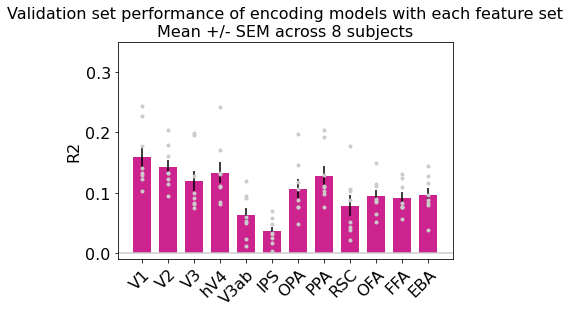

In [46]:
# Plot just the midlevel models

# mm2plot = [0,1,2,3,4]
mm2plot = [4]

# colors = cm.BuPu(np.linspace(0,1,5))[1:2,:]
colors = cm.RdPu(np.linspace(0,1,4))[2:3,:]
# colors = np.concatenate([colors, dnn_colors], axis=0)
# colors = cm.Purples(np.linspace(0,1,6))[1:5,:]

nc_thresh = 0.01

vals = np.zeros((n_subjects, n_rois, len(mm2plot)))

for fi, mm in enumerate(mm2plot):

    for si, ss in enumerate(subjects):

        val_r2 = out[mm][si]['val_r2'][:,0]    
        
        nc = nsd_utils.ncsnr_to_nc(out[fi][si]['voxel_ncsnr'][out[fi][si]['voxel_mask']])/100
        inds2use = nc>nc_thresh

        for ri in range(n_rois):

            inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & inds2use
        
            vals[si,ri,fi] = np.mean(val_r2[inds_this_roi])

mean_vals = np.mean(vals, axis=0)
sem_vals = np.std(vals, axis=0) / np.sqrt(n_subjects)

legend_separate=True
title='Validation set performance of encoding models with each feature set\nMean +/- SEM across 8 subjects'

plt.rcParams['pdf.fonttype']=42

plot_utils.set_all_font_sizes(fs = 16)
bw = 0.7;
space = (1 - (bw*mean_vals.shape[1]))/2
fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, \
                                point_data=vals,\
                                colors=colors, space=space, \
                xticklabels=roi_names, ylabel='R2', \
                ylim=[-0.01, 0.35], title=title, horizontal_line_pos=0,\
                legend_labels=np.array(feature_type_list)[mm2plot], \
                legend_overlaid=False, legend_separate=False, \
                fig_size=(6,4))


# plt.rcParams.update({'font.size': 10})
# plt.rcParams['ps.fonttype']=42    
fn2save = '/user_data/mmhender/imStat/figures/%s_R2.pdf'%feature_type_list[mm2plot[0]]
plt.savefig(fn2save)

In [47]:
fn2save

'/user_data/mmhender/imStat/figures/alexnet_R2.pdf'

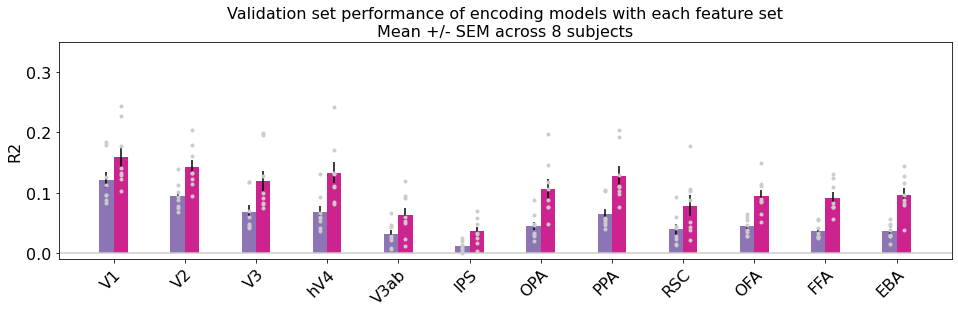

In [37]:
# Plot just the midlevel models

mm2plot = [0,4]
# mm2plot = [0,1,2,5]

colors = cm.BuPu(np.linspace(0,1,6))[3:4,:]
dnn_colors = cm.RdPu(np.linspace(0,1,4))[2:3,:]
colors = np.concatenate([colors, dnn_colors], axis=0)
# colors = cm.Purples(np.linspace(0,1,6))[1:5,:]

nc_thresh = 0.01

vals = np.zeros((n_subjects, n_rois, len(mm2plot)))

for fi, mm in enumerate(mm2plot):

    for si, ss in enumerate(subjects):

        val_r2 = out[mm][si]['val_r2'][:,0]    
        
        nc = nsd_utils.ncsnr_to_nc(out[fi][si]['voxel_ncsnr'][out[fi][si]['voxel_mask']])/100
        inds2use = nc>nc_thresh

        for ri in range(n_rois):

            inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & inds2use
        
            vals[si,ri,fi] = np.mean(val_r2[inds_this_roi])

mean_vals = np.mean(vals, axis=0)
sem_vals = np.std(vals, axis=0) / np.sqrt(n_subjects)

legend_separate=True
title='Validation set performance of encoding models with each feature set\nMean +/- SEM across 8 subjects'

plt.rcParams['pdf.fonttype']=42

plot_utils.set_all_font_sizes(fs = 16)
bw = 0.20;
space = (1 - (bw*mean_vals.shape[1]))/2
fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, \
                                point_data=vals,\
                                colors=colors, space=space, \
                xticklabels=roi_names, ylabel='R2', \
                ylim=[-0.01, 0.35], title=title, horizontal_line_pos=0,\
                legend_labels=np.array(feature_type_list)[mm2plot], \
                legend_overlaid=False, legend_separate=False, \
                fig_size=(16,4))


# plt.rcParams.update({'font.size': 10})
# plt.rcParams['ps.fonttype']=42    
fn2save = '/user_data/mmhender/imStat/figures/gabor_alexnet_R2.pdf'
plt.savefig(fn2save)

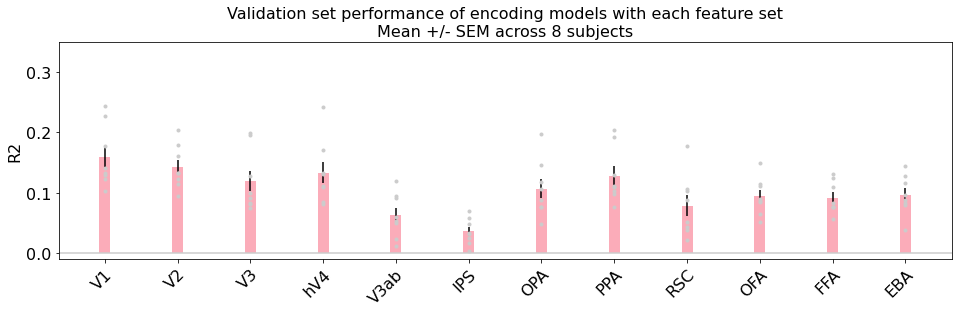

In [31]:
# Plot just the midlevel models

mm2plot = [4]


nc_thresh = 0.01

vals = np.zeros((n_subjects, n_rois, len(mm2plot)))

for fi, mm in enumerate(mm2plot):

    for si, ss in enumerate(subjects):

        val_r2 = out[mm][si]['val_r2'][:,0]    
        
        nc = nsd_utils.ncsnr_to_nc(out[fi][si]['voxel_ncsnr'][out[fi][si]['voxel_mask']])/100
        inds2use = nc>nc_thresh

        for ri in range(n_rois):

            inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & inds2use
        
            vals[si,ri,fi] = np.mean(val_r2[inds_this_roi])

mean_vals = np.mean(vals, axis=0)
sem_vals = np.std(vals, axis=0) / np.sqrt(n_subjects)

legend_separate=True
title='Validation set performance of encoding models with each feature set\nMean +/- SEM across 8 subjects'

plt.rcParams['pdf.fonttype']=42

plot_utils.set_all_font_sizes(fs = 16)
bw = 0.15;
space = (1 - (bw*mean_vals.shape[1]))/2
fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, \
                                point_data=vals,\
                                colors=dnn_colors, space=space, \
                xticklabels=roi_names, ylabel='R2', \
                ylim=[-0.01, 0.35], title=title, horizontal_line_pos=0,\
                legend_labels=np.array(feature_type_list)[mm2plot], \
                legend_overlaid=False, legend_separate=False, \
                fig_size=(16,4))


# plt.rcParams.update({'font.size': 10})
# plt.rcParams['ps.fonttype']=42    
fn2save = '/user_data/mmhender/imStat/figures/alexnet_R2.pdf'
plt.savefig(fn2save)

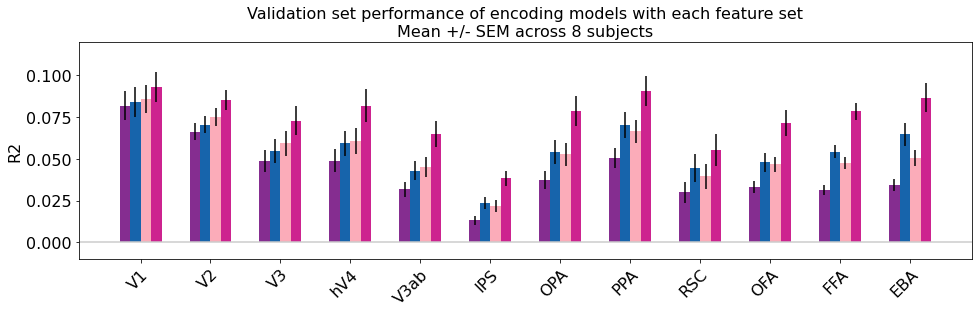

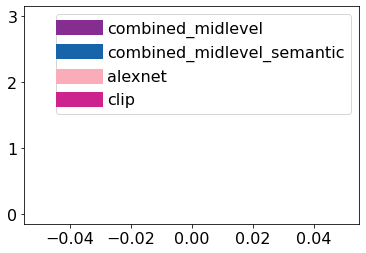

In [63]:
# Plot the DNN models

mm2plot = [5,6, 3,4]

dnn_colors = cm.RdPu(np.linspace(0,1,4))[1:3,:]
midlevel_color = cm.BuPu(np.linspace(0,1,6))[4:5,:]
# combined_color = np.array([[0.4, 0.4, 0.4, 1]])
combined_color = cm.Blues(np.linspace(0,1,6))[4:5,:]

colors = np.concatenate([midlevel_color, combined_color, dnn_colors], axis=0)

nc_thresh = 0.01

vals = np.zeros((n_subjects, n_rois, len(mm2plot)))

for fi, mm in enumerate(mm2plot):

    for si, ss in enumerate(subjects):

        val_r2 = out[mm][si]['val_r2'][:,0]    
        
        nc = nsd_utils.ncsnr_to_nc(out[fi][si]['voxel_ncsnr'][out[fi][si]['voxel_mask']])/100
        inds2use = nc>nc_thresh

        for ri in range(n_rois):

            inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & inds2use
        
            vals[si,ri,fi] = np.mean(val_r2[inds_this_roi])

mean_vals = np.mean(vals, axis=0)
sem_vals = np.std(vals, axis=0) / np.sqrt(n_subjects)

legend_separate=True
title='Validation set performance of encoding models with each feature set\nMean +/- SEM across 8 subjects'

plt.rcParams['pdf.fonttype']=42

plot_utils.set_all_font_sizes(fs = 16)
bw = 0.15;
space = (1 - (bw*mean_vals.shape[1]))/2
fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, colors=colors, space=space, \
                xticklabels=roi_names, ylabel='R2', \
                ylim=[-0.01, 0.12],title=title, horizontal_line_pos=0,\
                legend_labels=np.array(feature_type_list)[mm2plot], \
                legend_overlaid=False, legend_separate=True, \
                fig_size=(16,4))


# fn2save = '/user_data/mmhender/imStat/figures/DNNs_R2.pdf'
# plt.savefig(fn2save)

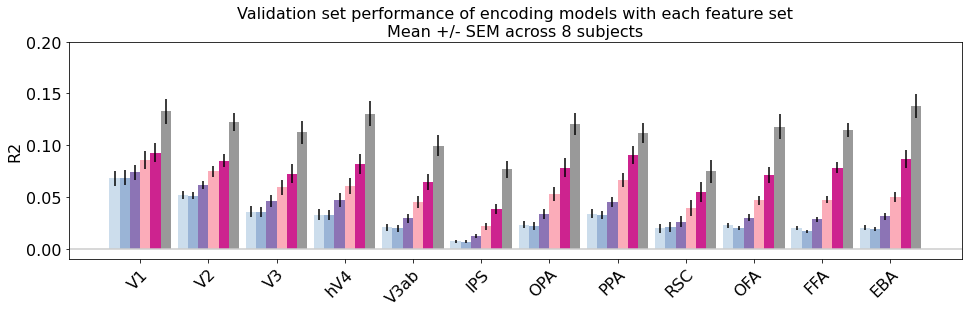

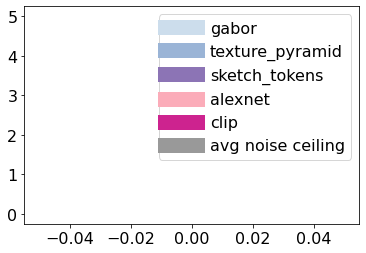

In [57]:
# Plot everything, plus noise ceiling

mm2plot = [0,1,2,3,4]

dnn_colors = cm.RdPu(np.linspace(0,1,4))[1:3,:]
midlevel_colors = cm.BuPu(np.linspace(0,1,6))[1:4,:]

colors = np.concatenate([midlevel_colors, dnn_colors], axis=0)

nc_thresh = 0.01

vals = np.zeros((n_subjects, n_rois, len(mm2plot)))

for fi, mm in enumerate(mm2plot):

    for si, ss in enumerate(subjects):

        val_r2 = out[mm][si]['val_r2'][:,0]    
        
        nc = nsd_utils.ncsnr_to_nc(out[fi][si]['voxel_ncsnr'][out[fi][si]['voxel_mask']])/100
        inds2use = nc>nc_thresh

        for ri in range(n_rois):

            inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri) & inds2use
        
            vals[si,ri,fi] = np.mean(val_r2[inds_this_roi])
            

nc_vals = np.zeros((n_subjects, n_rois, 1))

fi=0

for si, ss in enumerate(subjects):
    
    voxel_ncsnr = out[fi][si]['voxel_ncsnr'].ravel()[out[fi][si]['voxel_index'][0]]
    noise_ceiling = nsd_utils.ncsnr_to_nc(voxel_ncsnr)/100

    for ri in range(n_rois):

        inds_this_roi = roi_def.ss_roi_defs[si].get_indices(ri)

        nc_vals[si,ri,fi] = np.mean(noise_ceiling[inds_this_roi])

vals = np.concatenate([vals, nc_vals], axis=2)

colors = np.concatenate([colors, np.array([[0.6, 0.6, 0.6, 1]])], axis=0)

names = [feature_type_list[mm] for mm in mm2plot] + ['avg noise ceiling']

            
mean_vals = np.mean(vals, axis=0)
sem_vals = np.std(vals, axis=0) / np.sqrt(n_subjects)



legend_separate=True
title='Validation set performance of encoding models with each feature set\nMean +/- SEM across 8 subjects'

plt.rcParams['pdf.fonttype']=42

plot_utils.set_all_font_sizes(fs = 16)
bw = 0.15;
space = (1 - (bw*mean_vals.shape[1]))/2

fh = plot_utils.plot_multi_bars(mean_data=mean_vals, err_data=sem_vals, colors=colors, space=space, \
                xticklabels=roi_names, ylabel='R2', \
                ylim=[-0.01, 0.20], title=title, horizontal_line_pos=0,\
                legend_labels=names, \
                legend_overlaid=False, legend_separate=True, \
                fig_size=(16,4))


# plt.rcParams.update({'font.size': 10})
# plt.rcParams['ps.fonttype']=42    
# fn2save = '/user_data/mmhender/imStat/figures/lower_level_visual_R2.pdf'
# plt.savefig(fn2save)